In [3]:
# Imports for data processing, models and visualization
import os
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import warnings

warnings.filterwarnings("ignore")

In [7]:
train_folder = '/kaggle/input/handwritten-digits-0-9'
sample_folder = '/kaggle/input/digitsdata'
img_size = (20, 20)
max_per_class = 2000
test_size = 0.2
random_seed = 42
n_neighbors = 3

random.seed(random_seed)
np.random.seed(random_seed)

In [8]:
# Function to load images from a folder where each class is a subfolder named by label
def load_images_from_folder(base_folder, size=(20,20), max_per_class=None):
    """
    Load grayscale images from subfolders.
    Each subfolder name is treated as class label.
    Returns X (n_samples, n_features) and y (n_samples,)
    """
    X = []
    y = []
    if not os.path.exists(base_folder):
        print(f"Folder not found: {base_folder}")
        return np.array(X), np.array(y)

    for label_folder in sorted(os.listdir(base_folder)):
        folder_path = os.path.join(base_folder, label_folder)
        if not os.path.isdir(folder_path):
            continue
        # collect files and optionally limit per class
        files = glob.glob(os.path.join(folder_path, '*.jpg')) + glob.glob(os.path.join(folder_path, '*.png')) + glob.glob(os.path.join(folder_path, '*.jpeg'))
        if len(files) == 0:
            continue
        random.shuffle(files)
        if max_per_class:
            files = files[:max_per_class]
        for f in files:
            img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
            # normalize to [0,1]
            img_norm = img_resized.astype(np.float32) / 255.0
            X.append(img_norm.flatten())
            y.append(label_folder)
    return np.array(X, dtype=np.float32), np.array(y)

In [9]:
# Load dataset from folder structured as: base_folder/<label>/*.png
X, y = load_images_from_folder(train_folder, size=img_size, max_per_class=max_per_class)

if X.size == 0:
    print("No training images were loaded. Check 'train_folder' path.")
else:
    print(f"Loaded {X.shape[0]} images with feature size {X.shape[1]}")
    # encode labels to integers
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    classes = le.classes_
    print("Classes found:", classes)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=test_size, random_state=random_seed, stratify=y_enc)
    print(f"Train: {X_train.shape[0]} images, Test: {X_test.shape[0]} images")

Loaded 20000 images with feature size 400
Classes found: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Train: 16000 images, Test: 4000 images


In [10]:
# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric='euclidean')
knn.fit(X_train, y_train)
print("KNN training complete.")

KNN training complete.


Test accuracy: 0.8285

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       400
           1       0.79      0.98      0.87       400
           2       0.86      0.89      0.88       400
           3       0.78      0.80      0.79       400
           4       0.85      0.80      0.82       400
           5       0.82      0.79      0.80       400
           6       0.85      0.90      0.87       400
           7       0.85      0.87      0.86       400
           8       0.87      0.65      0.74       400
           9       0.83      0.69      0.75       400

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



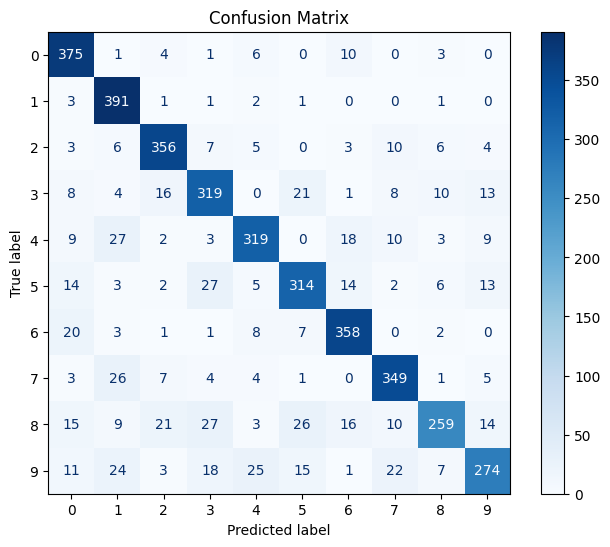

Per-class metrics (TP/FP/FN/TN):
Class 0: TP=375  FP=86  FN=25  TN=3514
Class 1: TP=391  FP=103  FN=9  TN=3497
Class 2: TP=356  FP=57  FN=44  TN=3543
Class 3: TP=319  FP=89  FN=81  TN=3511
Class 4: TP=319  FP=58  FN=81  TN=3542
Class 5: TP=314  FP=71  FN=86  TN=3529
Class 6: TP=358  FP=63  FN=42  TN=3537
Class 7: TP=349  FP=62  FN=51  TN=3538
Class 8: TP=259  FP=39  FN=141  TN=3561
Class 9: TP=274  FP=58  FN=126  TN=3542


In [11]:
# Predictions on test set
y_pred_test = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred_test)
print(f"Test accuracy: {acc:.4f}\n")

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred_test, target_names=classes, zero_division=0))

# Confusion matrix and display
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Compute TP, FP, FN, TN for each class
metrics = {}
n_classes = len(classes)
for i in range(n_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics[classes[i]] = {"TP": int(TP), "FP": int(FP), "FN": int(FN), "TN": int(TN)}

print("Per-class metrics (TP/FP/FN/TN):")
for cls, m in metrics.items():
    print(f"Class {cls}: TP={m['TP']}  FP={m['FP']}  FN={m['FN']}  TN={m['TN']}")

In [12]:
# Utility: show images in a grid with optional titles
def show_images_grid(images, titles=None, cols=5, cmap='gray'):
    """
    Show a list/array of 2D images in a grid.
    """
    n = len(images)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    for i in range(len(axes)):
        ax = axes[i]
        if i < n:
            ax.imshow(images[i], cmap=cmap)
            if titles is not None:
                ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Utility: plot predictions vs actual on a dataset X,y (expects flattened images)
def plot_predictions_grid(X_flat, y_true, y_pred=None, label_encoder=None, cols=5):
    """
    Plot images from flattened array X_flat with titles showing actual and predicted labels.
    """
    imgs = [x.reshape(img_size) for x in X_flat]
    titles = []
    for i in range(len(imgs)):
        true_label = label_encoder.inverse_transform([y_true[i]])[0] if label_encoder is not None else str(y_true[i])
        if y_pred is not None:
            pred_label = label_encoder.inverse_transform([y_pred[i]])[0] if label_encoder is not None else str(y_pred[i])
            titles.append(f"A:{true_label} P:{pred_label}")
        else:
            titles.append(f"A:{true_label}")
    show_images_grid(imgs, titles=titles, cols=cols)

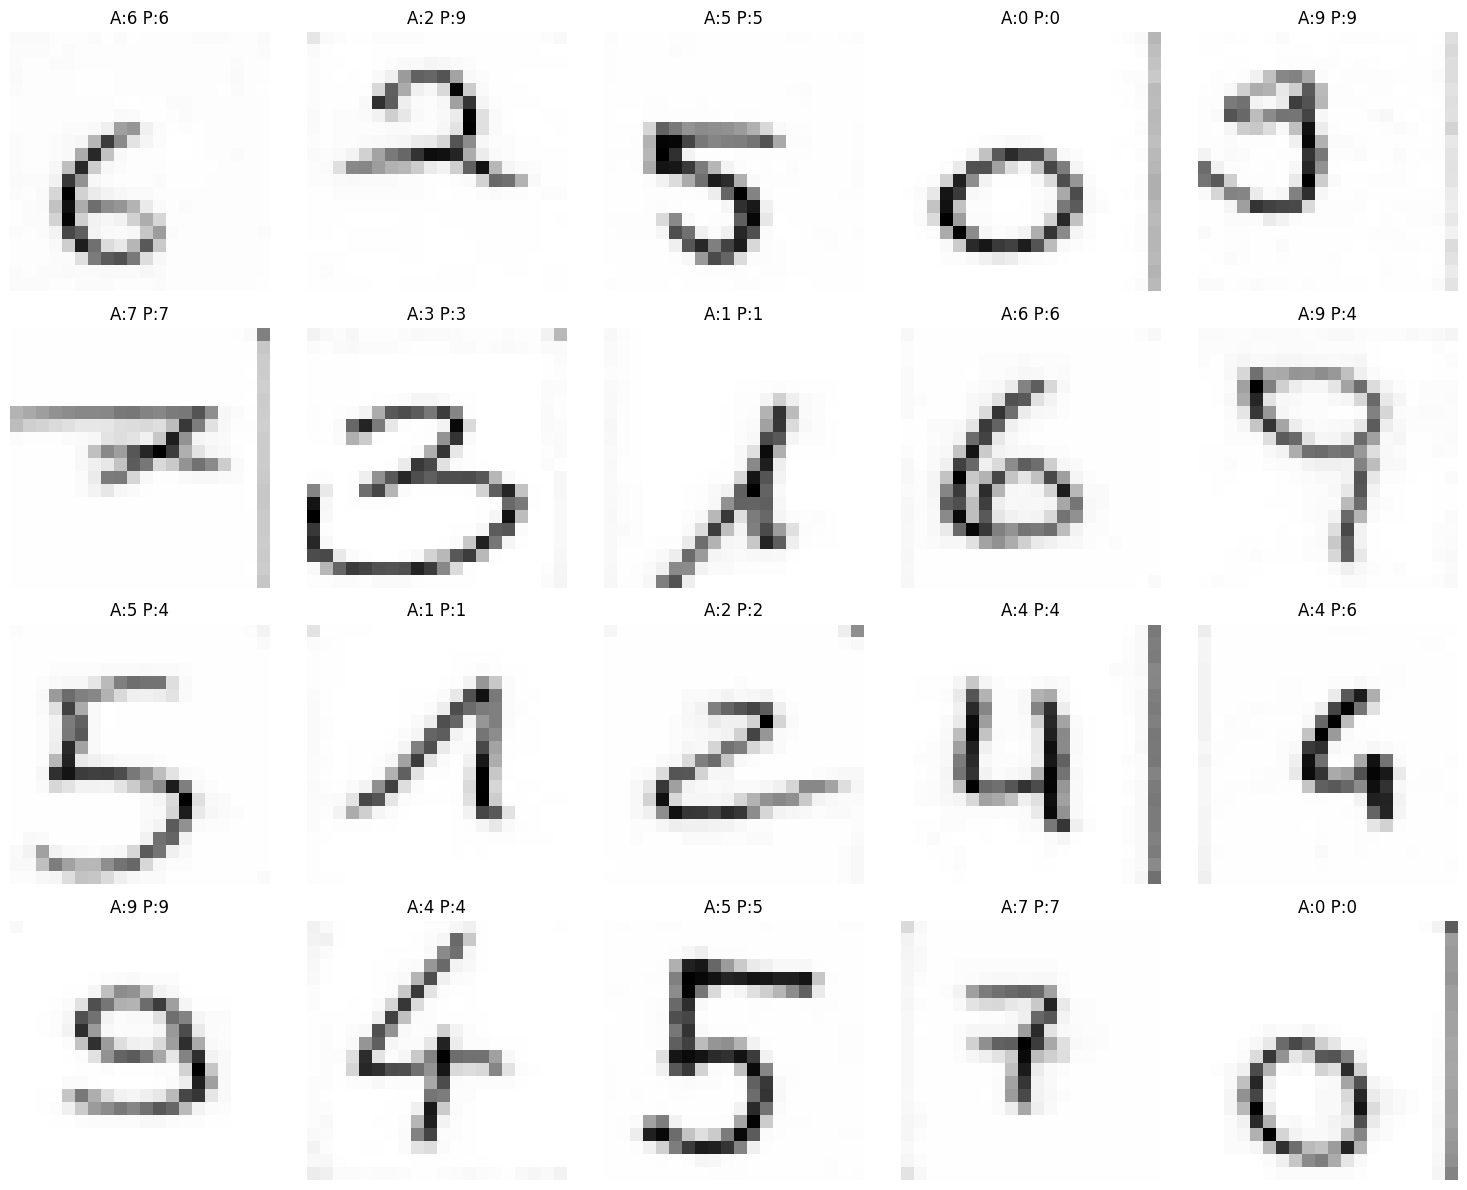

In [13]:
# Show first 20 test images with predictions
num_to_show = min(20, X_test.shape[0])
y_pred_subset = knn.predict(X_test[:num_to_show])
plot_predictions_grid(X_test[:num_to_show], y_test[:num_to_show], y_pred=y_pred_subset, label_encoder=le, cols=5)

Predictions for sample files: ['0' '9' '2' '3' '9' '3' '6' '7' '3' '9']


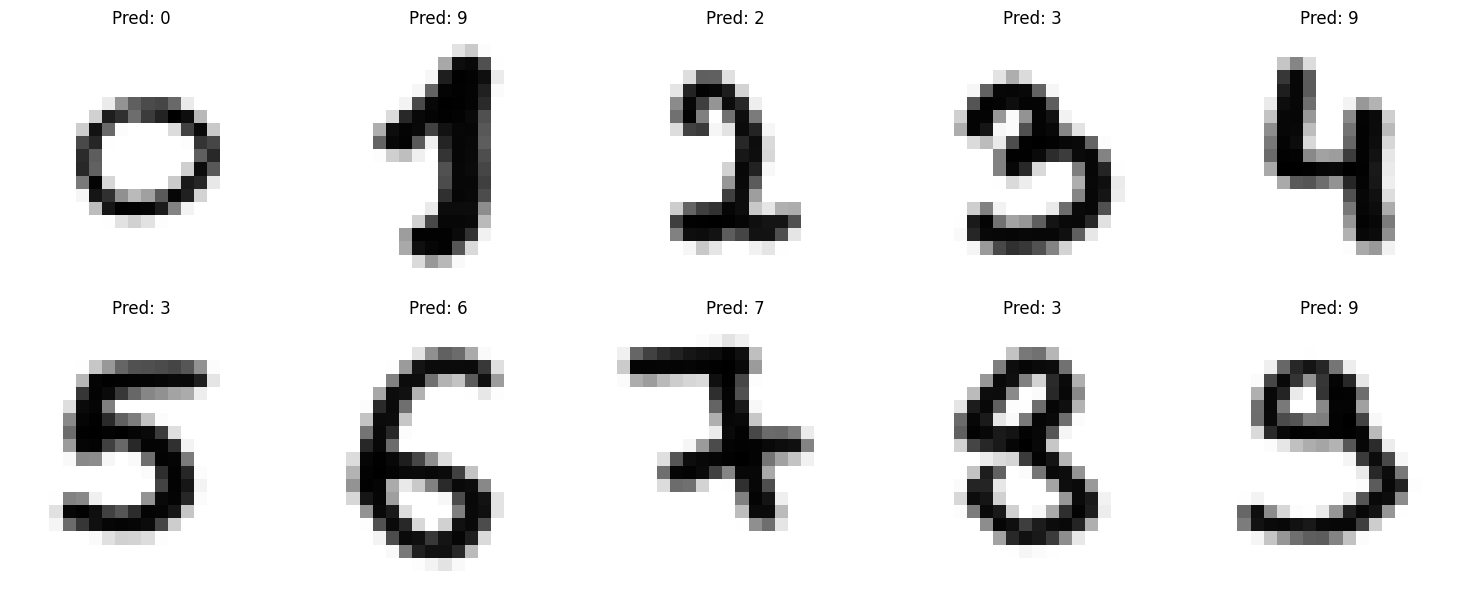

In [14]:
# Function to predict on arbitrary image files (single-level folder with images)
def predict_from_files(knn_model, files_list, size=(20,20), label_encoder=None):
    """
    Read files, preprocess, predict with knn_model, and return predicted labels (decoded if label_encoder provided).
    """
    X = []
    images_display = []
    for f in files_list:
        if not os.path.exists(f):
            print(f"File not found: {f}")
            continue
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Cannot read: {f}")
            continue
        img_resized = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
        images_display.append(img_resized)
        X.append(img_resized.astype(np.float32).flatten() / 255.0)
    if len(X) == 0:
        return []
    X = np.array(X, dtype=np.float32)
    preds = knn_model.predict(X)
    if label_encoder is not None:
        preds_decoded = label_encoder.inverse_transform(preds)
        return preds_decoded, images_display
    return preds, images_display

# Example: predict for the 0..9 pngs (change paths to your actual files)
sample_files = [
    os.path.join(sample_folder, f'{i}.png') for i in range(10)
]

preds, imgs = predict_from_files(knn, sample_files, size=img_size, label_encoder=le)
print("Predictions for sample files:", preds)
if imgs:
    titles = [f"Pred: {p}" for p in preds]
    show_images_grid(imgs, titles=titles, cols=5)

In [16]:
# =====================================================
# TP, FP, FN, TN for each class
# =====================================================
metrics = {}
classes_list = le.classes_  # або np.unique(y) якщо не використовуєш LabelEncoder
n_classes = len(classes_list)

for i in range(n_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics[classes_list[i]] = {"TP": int(TP), "FP": int(FP), "FN": int(FN), "TN": int(TN)}

print("\nMetrics for each digit:")
for cls, m in metrics.items():
    print(f"Digit {cls}: TP={m['TP']}  FP={m['FP']}  FN={m['FN']}  TN={m['TN']}")



Metrics for each digit:
Digit 0: TP=375  FP=86  FN=25  TN=3514
Digit 1: TP=391  FP=103  FN=9  TN=3497
Digit 2: TP=356  FP=57  FN=44  TN=3543
Digit 3: TP=319  FP=89  FN=81  TN=3511
Digit 4: TP=319  FP=58  FN=81  TN=3542
Digit 5: TP=314  FP=71  FN=86  TN=3529
Digit 6: TP=358  FP=63  FN=42  TN=3537
Digit 7: TP=349  FP=62  FN=51  TN=3538
Digit 8: TP=259  FP=39  FN=141  TN=3561
Digit 9: TP=274  FP=58  FN=126  TN=3542


In [15]:
# Compare accuracy for several k values quickly
k_values = [1, 2, 3, 4, 5, 7, 9]
results = {}
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[k] = accuracy_score(y_test, y_pred)

print("k vs accuracy:")
for k, acc in results.items():
    print(f"k={k}: accuracy={acc:.4f}")

k vs accuracy:
k=1: accuracy=0.8237
k=2: accuracy=0.8237
k=3: accuracy=0.8285
k=4: accuracy=0.8255
k=5: accuracy=0.8207
k=7: accuracy=0.8135
k=9: accuracy=0.8015
